In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

# Problem Definition

In [17]:
# Van der Pol oscillator
#http://kitchingroup.cheme.cmu.edu/blog/2013/02/02/Solving-a-second-order-ode/

mu = 1.
def f(t, y):
    # dx/dt = mu(x - 1/3*x**3 - y)
    # dy/dt = mu/x
    return [mu*(y[0] - (y[0]**3)/3. - y[1]), y[0]/mu]


y0_list = [1, 2] 

t = np.linspace(0, 10, 40).reshape(-1, 1) #training points
# use non-uniform spacing instead
#t = np.concatenate([np.linspace(0, 4, 20), np.linspace(4.1, 10, 15)])
t = t.reshape(-1, 1)

# Reference solution

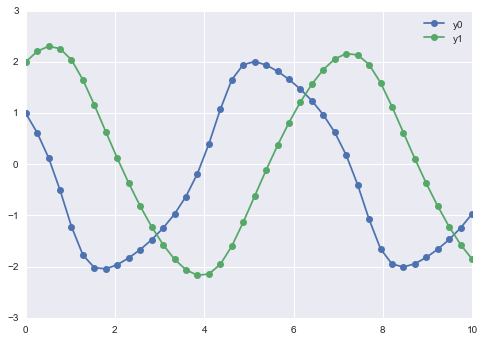

In [18]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                t_eval=t.ravel(), method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='y0')
plt.plot(sol.t, sol.y[1], marker='o', label='y1')
plt.legend()

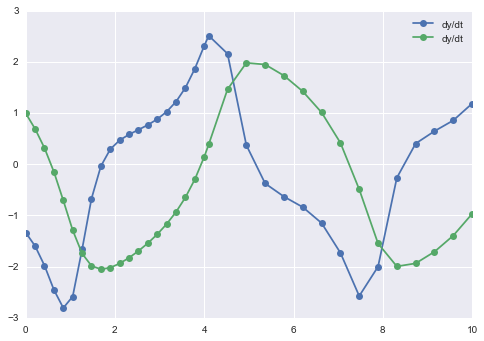

In [6]:
# reference solution using scipy package
plt.plot(sol.t, f(sol.t, sol.y)[0], marker='o', label='dy/dt')
plt.plot(sol.t, f(sol.t, sol.y)[1], marker='o', label='dy/dt')
plt.legend()

# Neural Net Training

In [7]:
nn = NNSolver(f, t, y0_list, n_hidden=20)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [1, 2] 
Numnber of hidden units:   20 
Number of training points: 40 

In [8]:
nn.reset_weights()
%time nn.train(maxiter=1000, iprint=100)

iteration: 0 loss:  1942.6172641
iteration: 100 loss:  0.156296049434
iteration: 200 loss:  0.154898172093
iteration: 300 loss:  0.110068784472
iteration: 400 loss:  0.048487492724
iteration: 500 loss:  0.029842675186
iteration: 600 loss:  0.0197487483511
iteration: 700 loss:  0.0122570071263
iteration: 800 loss:  0.00797800479758
iteration: 900 loss:  0.00229318350098
         Current function value: 0.001502
         Iterations: 1000
         Function evaluations: 1089
         Gradient evaluations: 1089
CPU times: user 12.6 s, sys: 104 ms, total: 12.7 s
Wall time: 12.8 s


# Verifying training set

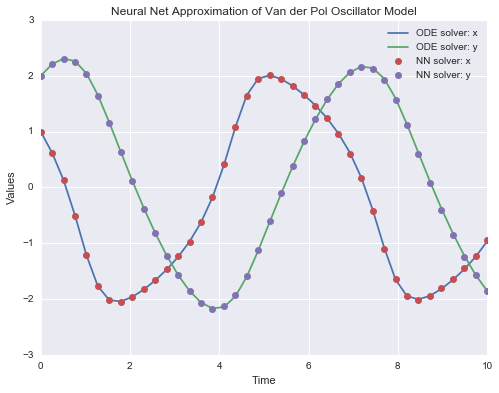

In [14]:
y_pred_list, dydt_pred_list = nn.predict()
# scipy sol
plt.figure(figsize= (8, 6))
plt.plot(sol.t, sol.y[0], label='ODE solver: x')
plt.plot(sol.t, sol.y[1], label='ODE solver: y')
# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN solver: x')
plt.plot(t, y_pred_list[1], 'o', label='NN solver: y')

plt.legend()
#plt.xlim((0, 3))

plt.title('Neural Net Approximation of Van der Pol Oscillator Model')
plt.ylabel('Values')
plt.xlabel('Time')


In [11]:
np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)])

0.013483056860111135

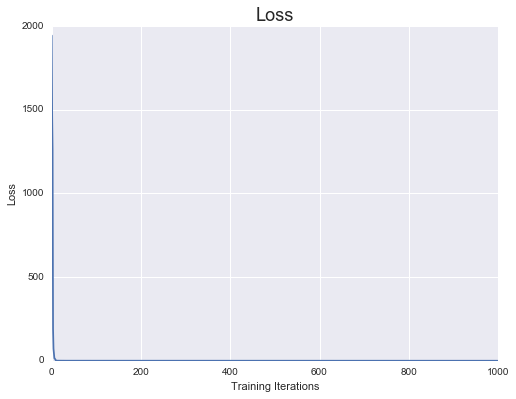

In [12]:
nn.plot_loss()

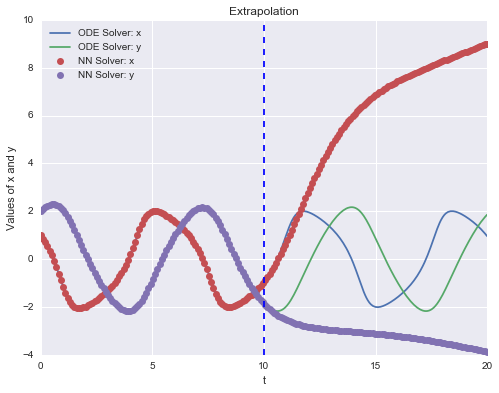

In [15]:
t_test = np.linspace(0., 20.0, 200).reshape(-1,1)

sol = solve_ivp(f, [t_test.min(), t_test.max()], y0_list, method='Radau', rtol=1e-5)
y_pred_list, dydt_pred_list = nn.predict(t=t_test)
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y[0], label='ODE Solver: x')
plt.plot(sol.t, sol.y[1], label='ODE Solver: y')

plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver: x')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver: y')
plt.axvline(x = 10 , linestyle = '--')
plt.legend(loc = 'best')
plt.title('Extrapolation')
plt.ylabel('Values of x and y')
plt.xlabel('t')

In [19]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(sol.y[i], y_pred_list[i])) for i in range(2)]))

iteration: 0 loss:  81.5844771881
         Current function value: 81.584477
         Iterations: 1
         Function evaluations: 17
         Gradient evaluations: 5
iteration: 0 loss:  537304.842936
iteration: 200 loss:  0.15649736425
iteration: 400 loss:  0.154902989399
         Current function value: 0.088564
         Iterations: 500
         Function evaluations: 581
         Gradient evaluations: 581
iteration: 0 loss:  18619754.3866
iteration: 200 loss:  0.156584099594
iteration: 400 loss:  0.154454133275
         Current function value: 0.079682
         Iterations: 500
         Function evaluations: 578
         Gradient evaluations: 578
iteration: 0 loss:  1003.61890749
iteration: 200 loss:  0.156077907641
iteration: 400 loss:  0.0860527684603
         Current function value: 0.049784
         Iterations: 500
         Function evaluations: 578
         Gradient evaluations: 567
iteration: 0 loss:  995.514312044
iteration: 200 loss:  0.156676725272
iteration: 400 loss:  0.155

(array([ 63.,   4.,   4.,   7.,   6.,   5.,   0.,   6.,   4.,   1.]), array([  0.03520182,   2.62751583,   5.21982984,   7.81214385,
        10.40445787,  12.99677188,  15.58908589,  18.1813999 ,
        20.77371391,  23.36602792,  25.95834193]), <a list of 10 Patch objects>)


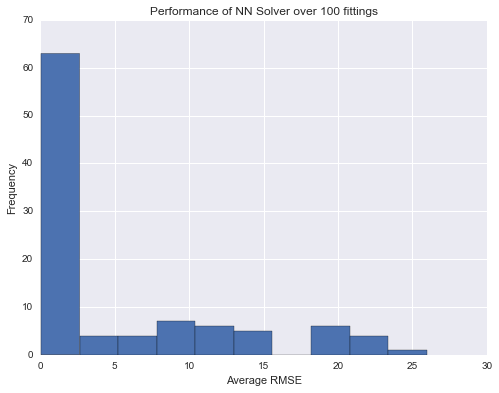

In [21]:
plt.figure(figsize= (8, 6))
figr = plt.hist(res_arr)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figr)